In [9]:
from templates import *
import matplotlib.pyplot as plt
import lmdb
import numpy as np
from PIL import Image
import pickle
import seaborn as sns
from sklearn.metrics import mean_squared_error

# encode with trained model

## load model

In [2]:
device = 'cuda:0'
conf = ffhq128_autoenc_130M()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 122.58 M


## load EEG

In [3]:
with open ("datasets/EEG_images.pickle","rb") as handle:
   EEG_images=pickle.load(handle)

with open ("datasets/EEG_labels.pickle","rb") as handle:
   EEG_labels=pickle.load(handle)

In [7]:
index=0
key = f'data-{str(index).zfill(5)}'.encode('utf-8')
img_bytes = txn.get(key)
data = pickle.loads(img_bytes)

EEG = data["data"].astype(np.float32)
label=data["label"]
subject=data["subject"]
image=data["image"]

data_EEG= NumpyDataset([EEG])
batch_EEG= data_EEG[0]['EEG'][None]

cond_eeg = model.encode(batch_EEG.to(device))
xT_pred = model.encode_stochastic(batch_EEG.to(device), cond_eeg, T=250)

In [9]:
type(xT_pred)

torch.Tensor

In [10]:
xT_pred

tensor([[[[ 4.9725e+00,  1.7899e-02, -5.4962e-02,  ..., -1.9016e-03,
           -1.9131e-03, -1.6146e-03],
          [ 2.6939e+00,  2.8229e-03,  9.5581e-02,  ..., -2.4185e-03,
           -2.4281e-03, -1.8806e-03],
          [-3.3092e-03, -7.7362e-03,  1.3285e+00,  ..., -2.4471e-03,
           -2.4433e-03, -1.8768e-03],
          ...,
          [-1.8368e-03, -2.4319e-03, -2.4147e-03,  ...,  3.3494e-02,
            1.2611e-02, -1.7395e-03],
          [-1.8234e-03, -2.4242e-03, -2.4242e-03,  ..., -1.4744e-03,
           -8.4543e-04, -1.8539e-03],
          [-1.6804e-03, -2.0504e-03, -2.0428e-03,  ...,  1.0204e-03,
           -1.4410e-03, -1.5335e-03]]]], device='cuda:0')

In [17]:
Xt=np.random.normal(0,1,size=(1,1,256,256)).astype(np.float32)
Xt_torch = torch.from_numpy(Xt)
Xt_torch=Xt_torch.to('cuda:0')

In [18]:
Xt_torch

tensor([[[[-0.3736,  1.6504, -0.1475,  ...,  0.0960, -1.0492,  1.5281],
          [-1.2407,  1.4051,  0.6065,  ..., -1.2014,  0.5518, -0.7119],
          [-0.5779,  0.6954,  0.3914,  ..., -2.1439,  0.1954, -0.3005],
          ...,
          [ 0.8443, -0.7332,  2.0268,  ..., -0.2283, -0.0674, -0.6944],
          [ 1.3517, -1.1562, -0.6134,  ...,  0.0194, -0.8927,  2.2920],
          [ 0.0221, -0.8779, -0.7056,  ..., -0.0258,  2.0614, -1.4140]]]],
       device='cuda:0')

In [5]:
summery=[]
Xt=np.random.normal(0,1,size=(1,1,256,256)).astype(np.float32)
Xt = torch.from_numpy(Xt)
Xt=Xt.to('cuda:0')

env = lmdb.open(
            'datasets/EEGtest.lmdb',
            max_readers=32,
            readonly=True,
            lock=False,
            readahead=False,
            meminit=False,
        )
txn=env.begin(write=False)



n_arrays= int(txn.get("length".encode('utf-8')).decode())
for index in tqdm(range (n_arrays)):
    key = f'data-{str(index).zfill(5)}'.encode('utf-8')
    img_bytes = txn.get(key)
    data = pickle.loads(img_bytes)
    
    EEG = data["data"].astype(np.float32)
    label=data["label"]
    subject=data["subject"]
    image=data["image"]

    data_EEG= NumpyDataset([EEG])
    batch_EEG= data_EEG[0]['EEG'][None]
    
    cond_eeg = model.encode(batch_EEG.to(device))
    pred = model.render(Xt, cond_eeg, T=20)

    summery.append({"zsem":cond_eeg,"label":label,"image":image,"pred":pred})


  0%|          | 0/120 [00:00<?, ?it/s]

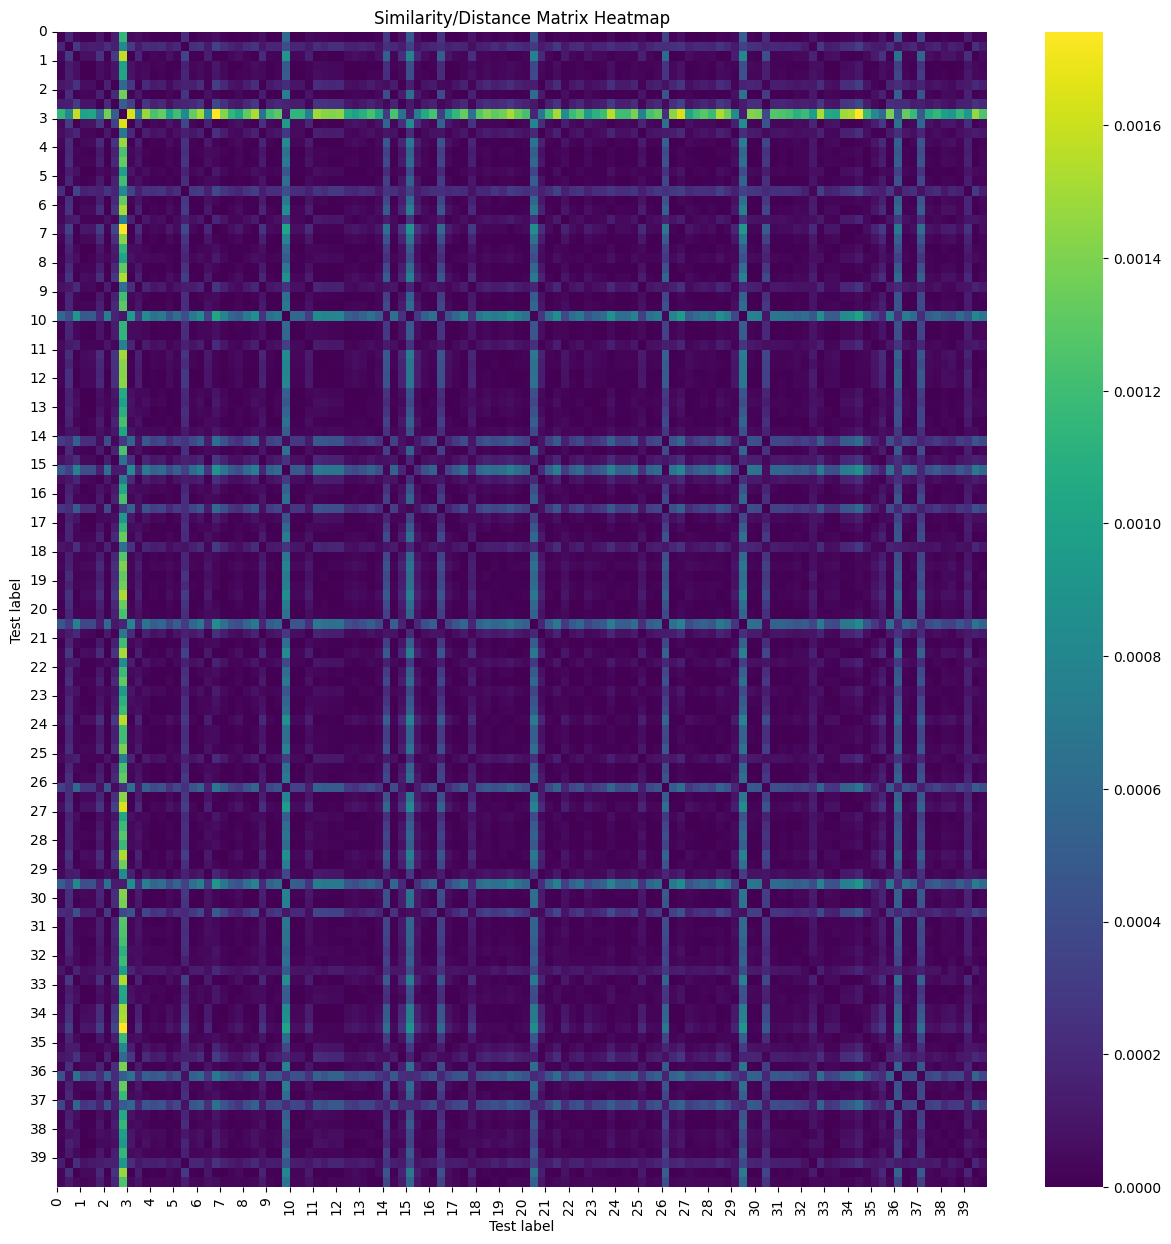

In [67]:
similarity_matrix = np.zeros((n_arrays, n_arrays))
sorted_summery = sorted(summery, key=lambda x: x['label'])
# Compute the MSE or other distance metric between each pair of arrays
xlabels=[]
for i in range(n_arrays):
    if i%3==0 : xlabels.append(sorted_summery[i]["label"])
    for j in range(i, n_arrays):  # Only compute the upper triangle
        mse = mean_squared_error(np.array(sorted_summery[i]["zsem"].tolist()), np.array(sorted_summery[j]["zsem"].tolist()))
        similarity_matrix[i, j] = mse
        similarity_matrix[j, i] = mse  # The matrix is symmetric

# Plot the similarity/distance matrix as a heatmap
# plt.figure(figsize=(10, 8))
fig, axs = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(similarity_matrix, annot=False, cmap='viridis')

axs.set_title('Similarity/Distance Matrix Heatmap')
axs.set_xlabel('Test label')
axs.set_ylabel('Test label')


    
axs.set_xticks(range(0,120,3), labels=xlabels)
axs.set_yticks(range(0,120,3), labels=xlabels)

plt.savefig("Similarity-Distance Matrix Heatmap.jpg")
plt.show()


In [69]:
# fig, ax = plt.subplots(1, 1, figsize=(15, 5))
from torchvision.utils import save_image
# plt.imshow(summery[0]["pred"][0].permute(1, 2, 0).cpu())
save_image(summery[0]["pred"][0].cpu(),"predicted/1.jpg")


# OLD

In [5]:
path1= "datasets/images/data/"+EEG_images[data1["image"]]+".JPEG"
path2= "datasets/images/data/"+EEG_images[data2["image"]]+".JPEG"

data = EEGImageDataset([path1,path2], image_size=256)

batch_image1 = data[0]['img'][None]
batch_image2 = data[1]['img'][None]

data_EEG= NumpyDataset([EEG1,EEG2])

batch_EEG1= data_EEG[0]['EEG'][None]
batch_EEG2= data_EEG[1]['EEG'][None]

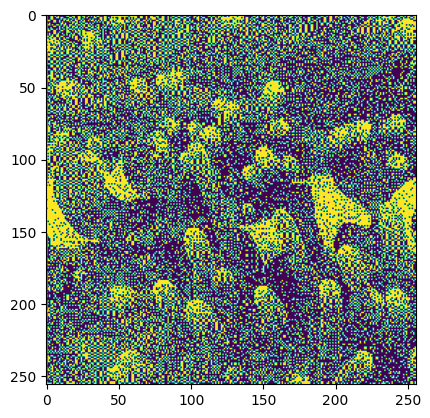

In [6]:
plt.imshow(batch_image1[0].permute([1, 2, 0]) / 2 + 0.5)

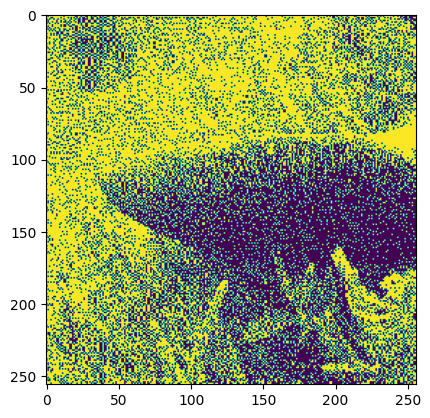

In [7]:
plt.imshow(batch_image2[0].permute([1, 2, 0]) / 2 + 0.5)

# test, EEG1 , Xt1 , decode(Xt1,zsem1)

In [8]:
cond_eeg1 = model.encode(batch_EEG1.to(device))
xT_pred = model.encode_stochastic(batch_EEG1.to(device), cond_eeg1, T=250)

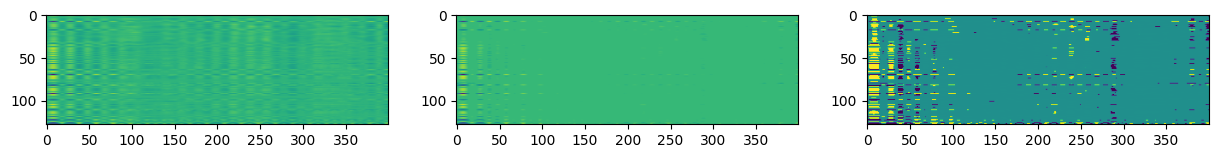

In [9]:
pred = model.render(xT_pred, cond_eeg1, T=20)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ori = (batch_EEG1 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT_pred[0].permute(1, 2, 0).cpu())
ax[2].imshow(pred[0].permute(1, 2, 0).cpu())

# zsem1 and image1 => Xt

In [10]:
cond_eeg1 = model.encode(batch_EEG1.to(device))
xT_pred = model.encode_stochastic(batch_image1.to(device), cond_eeg1, T=250)

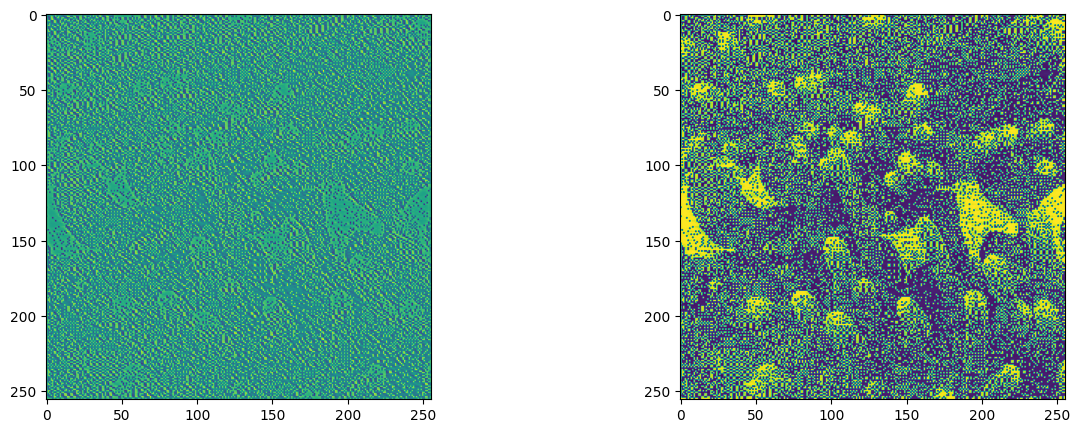

In [11]:
pred = model.render(xT_pred, cond_eeg1, T=20)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(xT_pred[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

# Xt and zsem2 => predicted image2

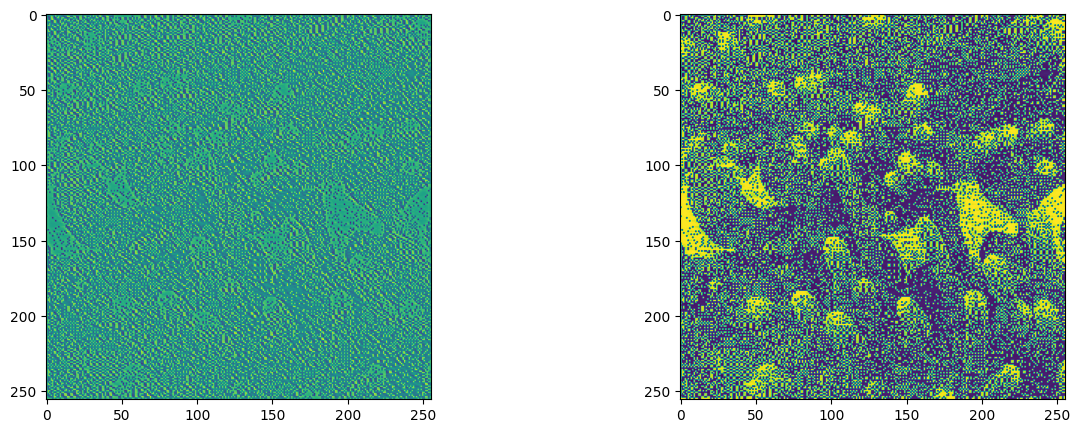

In [12]:
cond_eeg2 = model.encode(batch_EEG2.to(device))
pred = model.render(xT_pred, cond_eeg2, T=20)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(xT_pred[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

In [13]:
batch_EEG1

tensor([[[[ 0.3132,  0.2542,  0.1757,  ...,  0.1690,  0.2120,  0.2454],
          [ 0.1252, -0.0599, -0.2863,  ..., -0.5991, -0.5796, -0.5290],
          [-0.1131,  0.0504,  0.2838,  ..., -0.7525, -0.9028, -0.9922],
          ...,
          [ 0.3183,  0.6790,  1.1202,  ..., -0.4893, -0.5167, -0.4825],
          [ 1.3521,  0.3525, -1.0361,  ...,  1.5490,  1.9376,  2.1828],
          [-2.4937, -3.6610, -4.8913,  ...,  1.7419,  2.2230,  2.1009]]]])

In [14]:
batch_EEG2

tensor([[[[ 0.3009,  0.3779,  0.4687,  ..., -0.0859, -0.0332,  0.0468],
          [-0.3803, -0.4109, -0.3789,  ..., -0.1600, -0.2376, -0.2565],
          [ 0.3493,  0.0209, -0.3869,  ...,  0.1700,  0.1900,  0.1624],
          ...,
          [ 0.2768,  0.3002,  0.3292,  ..., -1.0514, -1.0308, -0.9657],
          [-0.2998, -0.6309, -1.0444,  ...,  0.1683,  0.1786,  0.1746],
          [ 0.9057,  1.8044,  2.7053,  ..., -1.7829, -2.1935, -2.0987]]]])

In [15]:
EEG1

array([[ 0.31315172,  0.25424418,  0.17574832, ...,  0.16898122,
         0.2120398 ,  0.24535708],
       [ 0.12518793, -0.05994182, -0.2862999 , ..., -0.5990952 ,
        -0.5795803 , -0.5289634 ],
       [-0.11308053,  0.05043848,  0.28380388, ..., -0.75249195,
        -0.90280545, -0.99223983],
       ...,
       [ 0.31832564,  0.6789854 ,  1.1202495 , ..., -0.48933163,
        -0.51668036, -0.48248672],
       [ 1.352062  ,  0.35254484, -1.0361459 , ...,  1.5490482 ,
         1.9375509 ,  2.1827824 ],
       [-2.4937036 , -3.6610224 , -4.8913474 , ...,  1.7418913 ,
         2.2229574 ,  2.100925  ]], dtype=float32)

In [16]:
cond_eeg2

tensor([[-4.8378e-01, -1.9910e-01, -1.1024e-03, -4.9248e-01,  1.4295e-01,
         -2.0241e-01, -3.4518e-01, -5.3206e-01,  4.8282e-01, -2.2059e-01,
         -6.7130e-02, -2.9641e-01,  4.6290e-01,  2.0793e-01,  1.0631e-01,
          7.4409e-01, -6.0873e-02,  2.1983e-01,  7.5329e-03,  1.2666e-01,
         -2.7187e-02, -5.2690e-01, -5.8505e-01, -3.6712e-01,  6.6615e-01,
          1.0717e+00,  1.7154e-01, -1.9969e-01, -4.8280e-02, -1.5304e-01,
          2.6607e-02,  1.3477e-01, -8.6954e-02, -7.1379e-01,  2.9712e-01,
          5.5125e-01,  8.2529e-02, -3.3189e-01, -4.4591e-01, -2.3466e-01,
         -1.4355e-01, -1.3888e-01,  3.0019e-01, -4.2437e-01,  3.8528e-01,
          2.7694e-01,  3.0224e-01, -6.5665e-01,  4.3957e-01,  1.5581e-01,
          4.7405e-01, -2.8885e-01, -8.4307e-01,  6.1126e-01, -4.2765e-01,
          3.5511e-01, -1.1372e-01,  1.9164e-01, -1.3654e-01, -7.4874e-02,
         -1.4013e-01, -5.2294e-02, -6.6080e-01,  3.1393e-01, -4.3118e-02,
         -3.5689e-01, -4.1167e-01,  2.

In [24]:
cond_eeg1

tensor([[-4.9321e-01, -2.0647e-01,  3.8048e-03, -5.0454e-01,  1.4988e-01,
         -2.0305e-01, -3.4968e-01, -5.4535e-01,  4.8849e-01, -2.3271e-01,
         -6.9078e-02, -3.0387e-01,  4.6816e-01,  2.1496e-01,  1.1152e-01,
          7.6190e-01, -6.7068e-02,  2.3471e-01,  5.8415e-03,  1.2124e-01,
         -2.7001e-02, -5.4623e-01, -5.9978e-01, -3.7631e-01,  6.6784e-01,
          1.0873e+00,  1.6662e-01, -2.0031e-01, -3.6358e-02, -1.5483e-01,
          3.0923e-02,  1.5001e-01, -9.2345e-02, -7.2616e-01,  3.0450e-01,
          5.6538e-01,  8.6815e-02, -3.3911e-01, -4.5614e-01, -2.4126e-01,
         -1.3963e-01, -1.4641e-01,  3.0164e-01, -4.2771e-01,  3.9372e-01,
          2.7853e-01,  3.1143e-01, -6.6703e-01,  4.5052e-01,  1.6918e-01,
          4.8742e-01, -3.0009e-01, -8.6063e-01,  6.2515e-01, -4.3363e-01,
          3.6340e-01, -1.2198e-01,  1.9754e-01, -1.4292e-01, -7.7537e-02,
         -1.4519e-01, -5.9628e-02, -6.7522e-01,  3.1936e-01, -4.2222e-02,
         -3.6546e-01, -4.1894e-01,  2.

# mean square

In [18]:
#mean squre
((np.array(cond_eeg1.tolist())-np.array(cond_eeg2.tolist()))**2).mean()

9.443103597904868e-05

# random zsem normal, mean=0, from -100 to 100

In [22]:
cond_test= cond_eeg2.clone()
for i in range (512):
    cond_test[0,i]= np.random.normal(0,100)


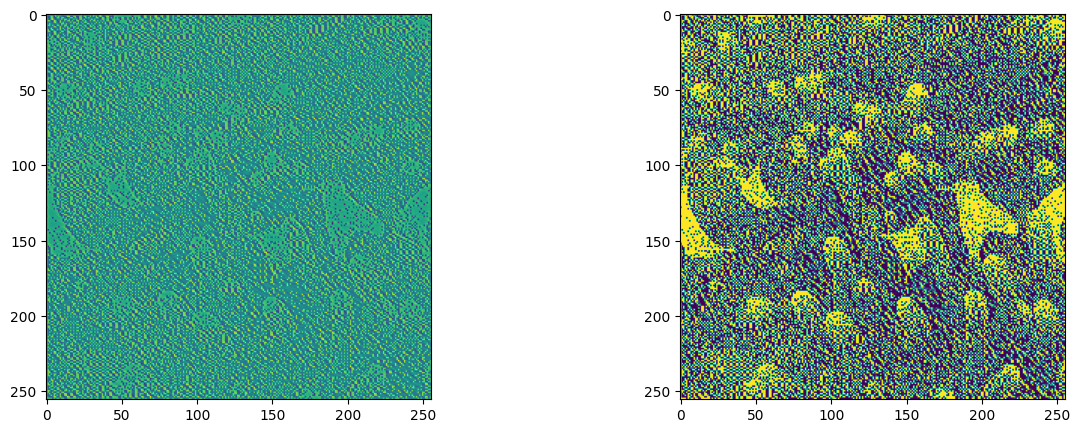

In [23]:
pred = model.render(xT_pred, cond_test, T=20)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(xT_pred[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())